In [1]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
path = 'N:/C2205_FAIRiCUBE/f02_data/d060_data_LUXEMBOURG/f05_distribution/f03_distribution_maxent/shap'
shap_values_df = pd.read_csv(path + '/20250307070928_impatiens_glandulifera_shap_values.csv', index_col=0)
# convert to ndarray
shap_values = shap_values_df.values
sample_features = pd.read_csv(path + '/20250307070928_impatiens_glandulifera_sample_values.csv', index_col=0)
species = 'Impatiens glandulifera'
sample_features.rename(columns={
    'd01_L_light': 'Shadow index', 
    'd02_F_wetness': 'Topographic wetness index',
    'd03_T_parameter_2017': 'Monthly mean temperature',
    'd05_R_ph': 'pH',
    'd06_N_nitrogen': 'Nitrogen',
    'd09_LV_landcover': 'Landcover'
}, inplace=True)

In [3]:
sample_features.columns

Index(['Shadow index', 'Topographic wetness index', 'Monthly mean temperature',
       'pH', 'Nitrogen', 'Landcover'],
      dtype='object')

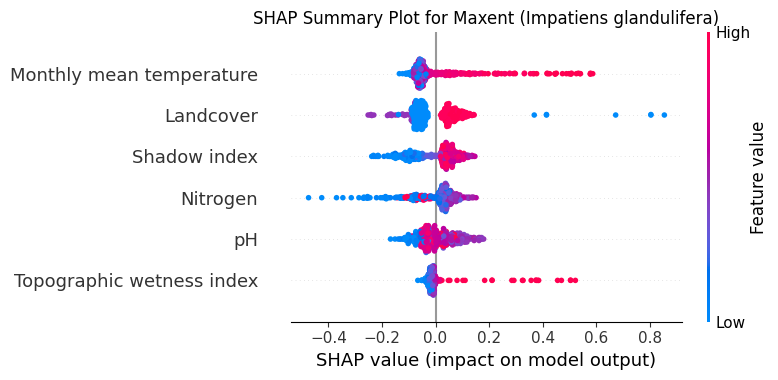

In [4]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, sample_features, show=False)
plt.title("SHAP Summary Plot for Maxent ("+species +")")
plt.tight_layout()



In [5]:
import numpy as np  
import matplotlib.patches as mpatches
# Compute global SHAP values using the sampled dataset
global_shap_values = np.mean(np.abs(shap_values), axis=0)

# Compute correlation between sampled feature values and SHAP values
feature_shap_correlation = []
for i, feature in enumerate(sample_features.columns):
    correlation = np.corrcoef(sample_features[feature], shap_values[:, i])[0, 1]  # Pearson correlation
    feature_shap_correlation.append(correlation)

# Create a DataFrame with feature importance and correlation
feature_importance_df = pd.DataFrame({
    'Feature': sample_features.columns,  # Use sampled features
    'Mean_Abs_SHAP': global_shap_values,
    'Correlation': feature_shap_correlation
})


In [6]:
feature_importance_df['col_corr'] = feature_importance_df.apply(lambda x: f"{x.Feature} ({x.Correlation:.2f})", axis=1)
feature_importance_df

,Feature,Mean_Abs_SHAP,Correlation,col_corr
0,Shadow index,0.070992,0.829319,Shadow index (0.83)
1,Topographic wetness index,0.027715,0.907470,Topographic wetness index (0.91)
2,Monthly mean temperature,0.087462,0.666927,Monthly mean temperature (0.67)
3,pH,0.051970,0.248675,pH (0.25)
4,Nitrogen,0.061661,0.183515,Nitrogen (0.18)
5,Landcover,0.075138,0.073054,Landcover (0.07)


In [13]:
feature_importance_df.where(feature_importance_df['Feature'] != 'Landcover').dropna().sort_values(by='Mean_Abs_SHAP', ascending=False).head(10)

,Feature,Mean_Abs_SHAP,Correlation,col_corr
2,Monthly mean temperature,0.087462,0.666927,Monthly mean temperature (0.67)
0,Shadow index,0.070992,0.829319,Shadow index (0.83)
4,Nitrogen,0.061661,0.183515,Nitrogen (0.18)
3,pH,0.051970,0.248675,pH (0.25)
1,Topographic wetness index,0.027715,0.907470,Topographic wetness index (0.91)


0.01
0.01
0.01
0.01
0.01


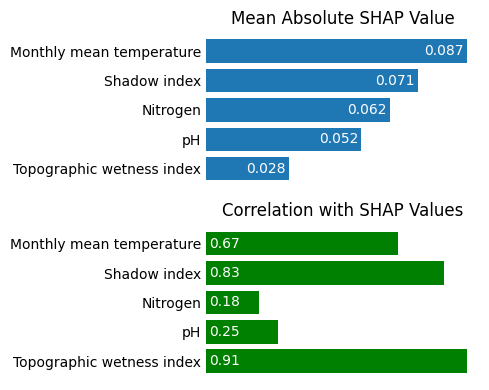

In [14]:

feature_importance_df = feature_importance_df.where(feature_importance_df['Feature'] != 'Landcover').dropna()
feature_importance_df.sort_values(by='Mean_Abs_SHAP', ascending=False, inplace=True)

sorted_features = feature_importance_df['Feature'].values
sorted_shap_values = feature_importance_df['Mean_Abs_SHAP'].values
sorted_correlation_values = feature_importance_df['Correlation'].values

colors = ['green' if corr > 0 else 'orange' for corr in sorted_correlation_values]
colors_redblue = ['blue' if corr > 0 else 'red' for corr in sorted_correlation_values]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5,4))
ax1.tick_params(axis=u'both', which=u'both',length=0)
ax2.tick_params(axis=u'both', which=u'both',length=0)
# ax2.yaxis.set_visible(False)
bars1 = ax1.barh(sorted_features, sorted_shap_values)  # Bars now sorted correctly
bars2 = ax2.barh(sorted_features, sorted_correlation_values, color=colors)
#set the x-axis label
# ax1.set_xlabel('Mean Absolute SHAP Value')
ax1.set_xticks([])
ax2.set_xticks([])
# add data labels to bars

# ax1.xlabel('Mean Absolute SHAP Value')
# set subplot title
ax1.title.set_text('Mean Absolute SHAP Value')
ax2.title.set_text('Correlation with SHAP Values')
# fig.suptitle.title(f'Global Feature Importance for Maxent Suitability ({species})')
# remove y-axis ticks but not the labels

for bar, corr in zip(bars1, sorted_shap_values):
    ax1.text(
        bar.get_width()-0.001,  # Position in the middle of the bar
        bar.get_y() + bar.get_height()/2,  # Centered in the bar
        f"{corr:.3f}",  # Format to 2 decimal places
        va='center', ha='right',  # Center text inside bar
        fontsize=10, 
        color='white',  # Improve readability
        # fontweight='bold'
    )

for bar, corr in zip(bars1, sorted_correlation_values):
    # get sign of correlation
    offset = np.sign(corr)*0.01
    print(offset)
    ax2.text(
        offset,  # Position in the middle of the bar
        bar.get_y() + bar.get_height()/2,  # Centered in the bar
        f"{corr:.2f}",  # Format to 2 decimal places
        va='center', ha='right' if corr<0 else 'left',  # Center text inside bar
        fontsize=10, 
        color='white' if offset > 0 else 'black',  # Improve readability
        # fontweight='bold'
    )

ax1.invert_yaxis()  # Ensure most important feature remains on top
ax2.invert_yaxis()  # Ensure most important feature remains on top
#set axis label font size
ax1.yaxis.label.set_size(12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
plt.tight_layout()